In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from multiprocess import Pool
from breads.utils import filter_spec_with_spline
from breads.atm_utils import miniRGI,rprint,silent

node_dict = np.load('fs_uniform_nodes_N136.npy',allow_pickle=True).item()

species v0.9.0

Working folder: /user/amadurowicz/51 Eri

Configuration file: /user/amadurowicz/51 Eri/species_config.ini
Database file: /user/amadurowicz/species_database.hdf5
Data folder: /user/amadurowicz/data

Configuration settings:
   - Database: /user/amadurowicz/species_database.hdf5
   - Data folder: /user/amadurowicz/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [2]:
load_base = 'saved/final/'
cube_files = glob.glob(load_base+'cube_*')
cube_files

['saved/final/cube_a1n1p.fits',
 'saved/final/cube_a2n1s.fits',
 'saved/final/cube_a1n2p.fits',
 'saved/final/cube_a2n1p.fits',
 'saved/final/cube_a1n2s.fits',
 'saved/final/cube_a1n1s.fits',
 'saved/final/cube_a2n2p.fits',
 'saved/final/cube_a2n2s.fits']

In [3]:
fluxes = {}
errs = {}
ras = {}
decs = {}
waves = {}
for f in cube_files:
    key = f.split('_')[-1].split('.')[0]
    #print(key)
    hdu = fits.open(f)
    fluxes[key] = hdu[0].data
    errs[key] = hdu[1].data
    ras[key] = hdu[2].data
    decs[key] = hdu[3].data
    waves[key] = hdu[4].data

i = fluxes['a1n1s'].shape[1]//2
j = fluxes['a1n1s'].shape[2]//2

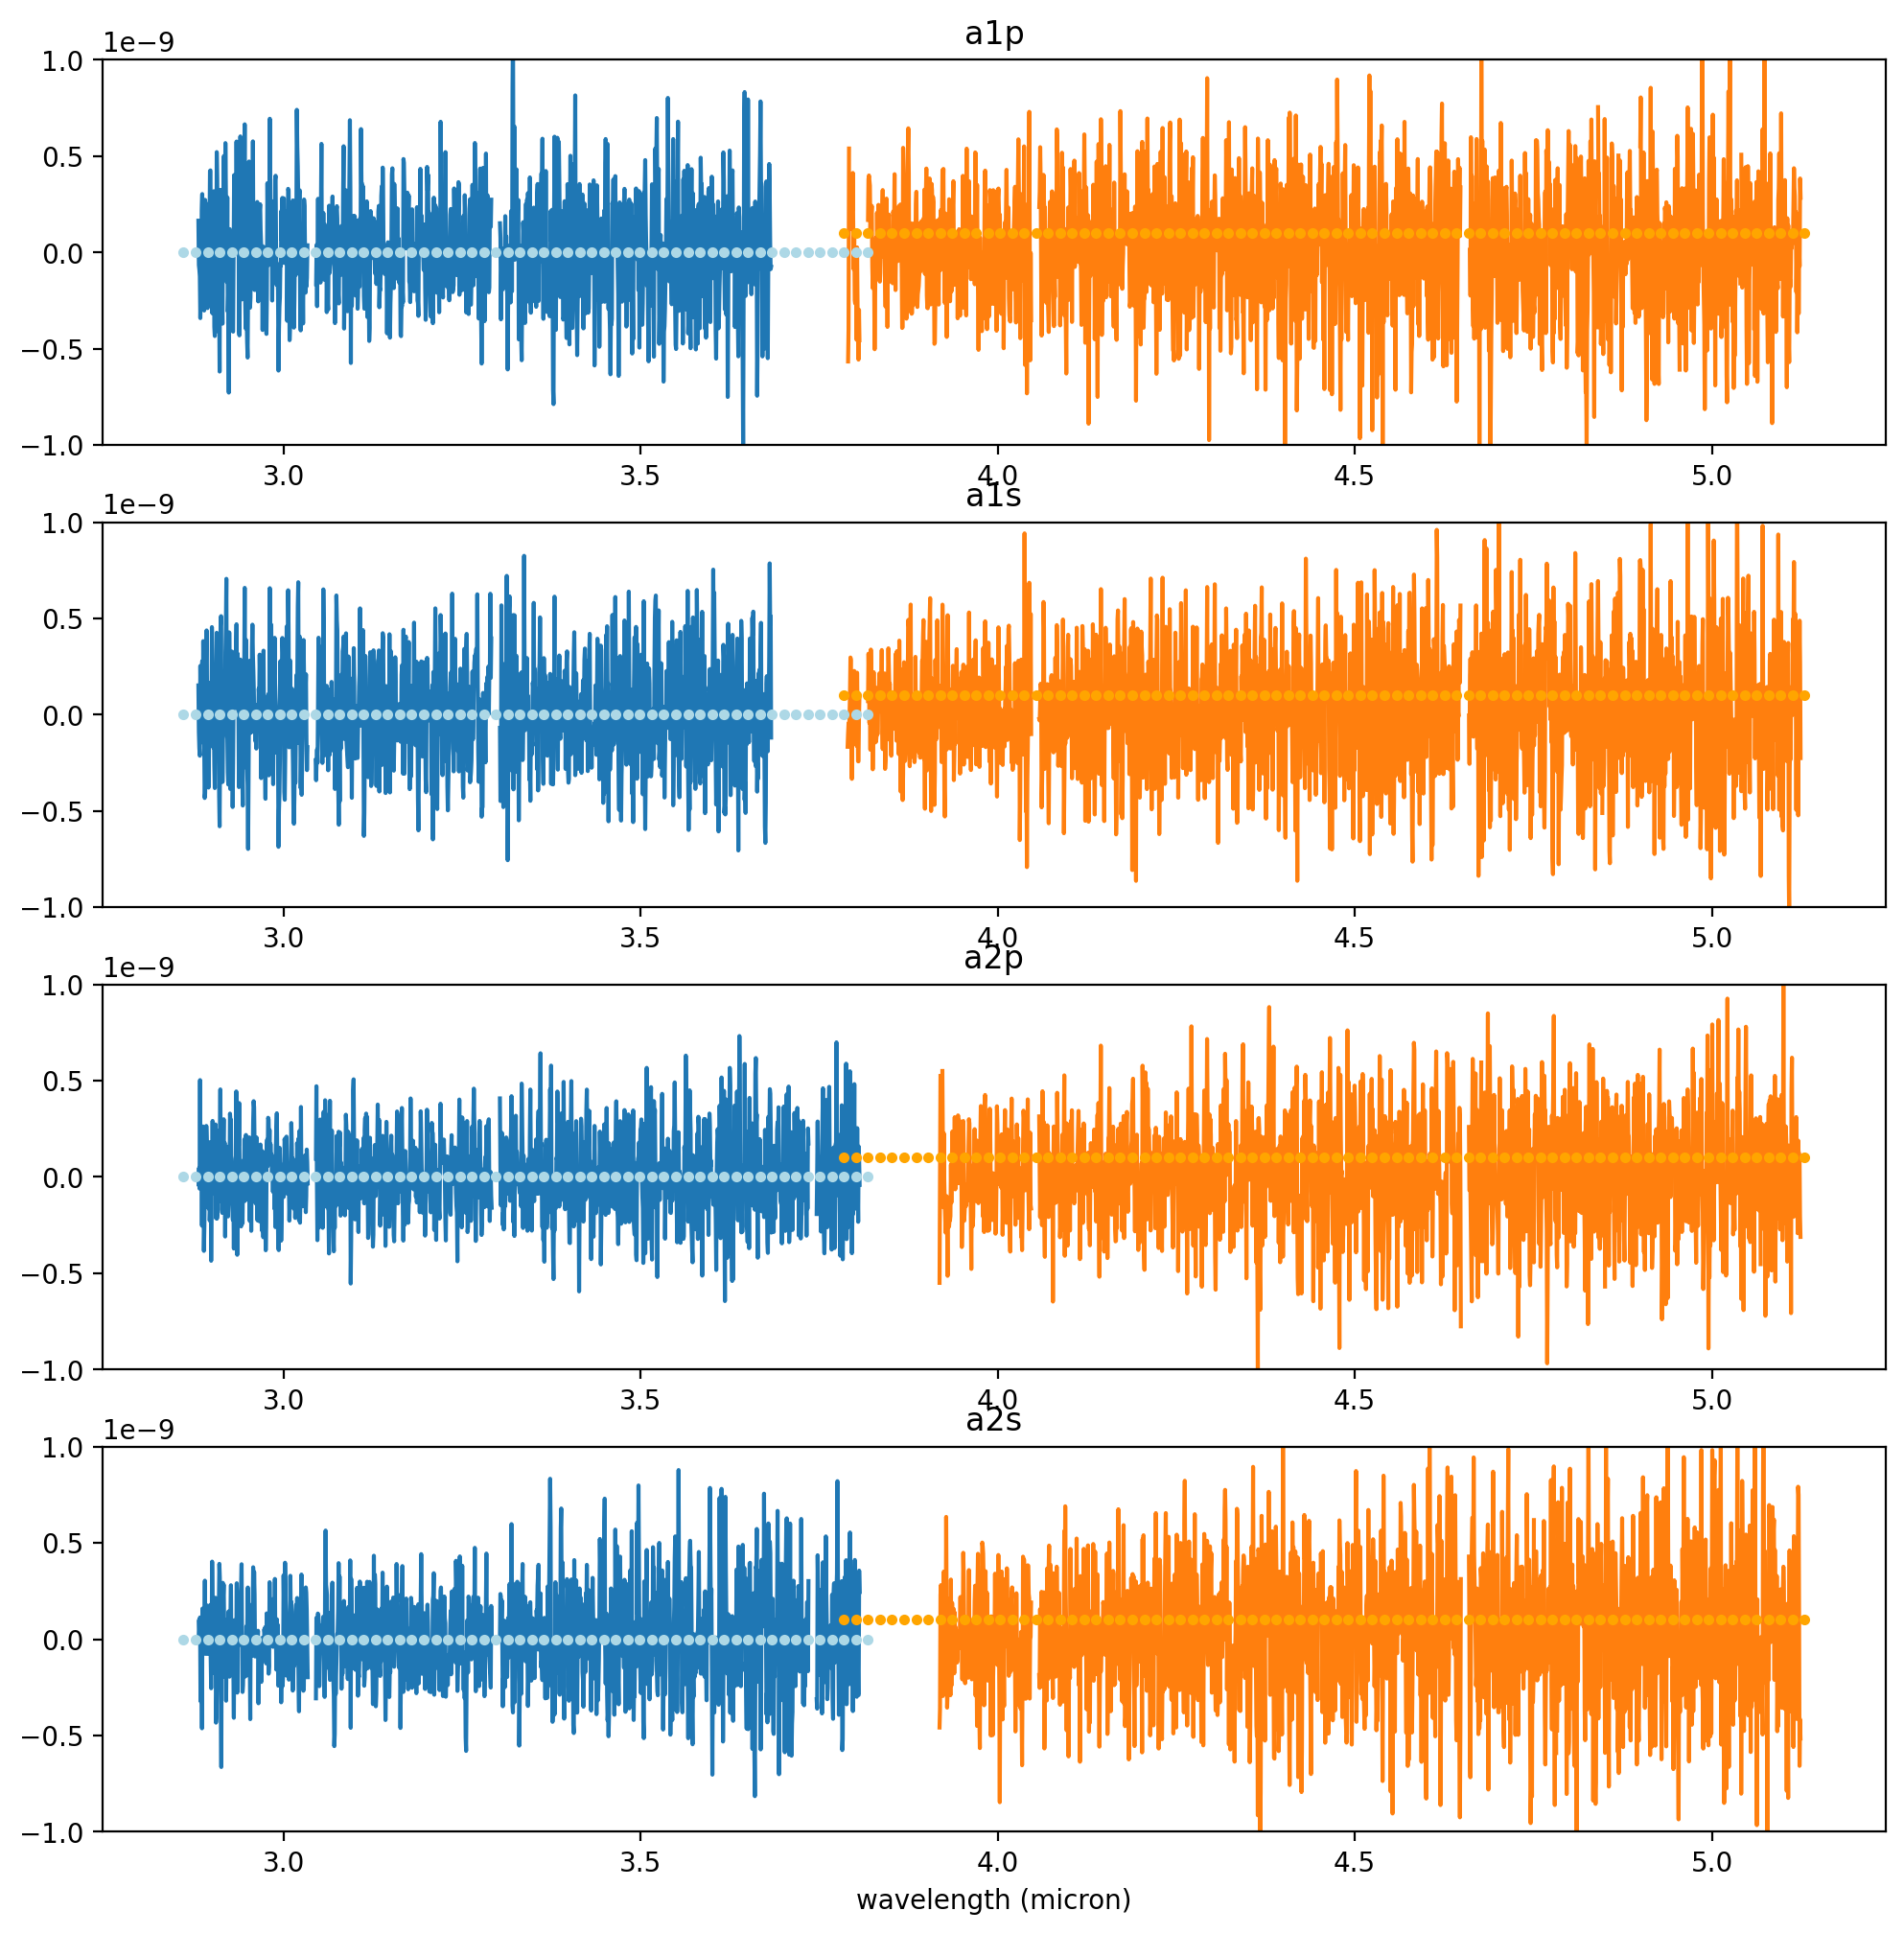

In [4]:
def extraction_diagnostic_plot():
    fig,ax = plt.subplots(4,1,dpi=200,figsize=(12,12))
    ind = 0 
    for halfkey in ['a1','a2']:
        for ps in ['p','s']:
            k1 = halfkey+'n1'+ps
            k2 = halfkey+'n2'+ps
    
            ax[ind].plot(waves[k1],fluxes[k1][:,i,j])
            ax[ind].plot(waves[k2],fluxes[k2][:,i,j])
            ax[ind].plot(node_dict['nrs1'],np.zeros(len(node_dict['nrs1'])),'.',color='lightblue')
            ax[ind].plot(node_dict['nrs2'],np.zeros(len(node_dict['nrs2']))+1e-10,'.',color='orange')
            ax[ind].set_title('{}{}'.format(halfkey,ps))
            ax[ind].set_ylim([-1e-9,1e-9])
            ind += 1
    ax[-1].set_xlabel('wavelength (micron)')
    plt.show()
extraction_diagnostic_plot()

In [5]:
full_keys = []
full_ws = {}
full_fluxes = {}
full_errs = {}

for halfkey in ['a1','a2']:
    for ps in ['p','s']:
        k1 = halfkey+'n1'+ps
        k2 = halfkey+'n2'+ps

        ap = halfkey+ps
        full_keys.append(ap)

        full_w = np.concatenate([waves[k1],waves[k2]])
        full_flux = np.vstack([fluxes[k1][:,:,j],fluxes[k2][:,:,j]])
        full_err = np.vstack([errs[k1][:,:,j],errs[k2][:,:,j]])
        full_ws[ap] = full_w
        full_fluxes[ap] = full_flux
        full_errs[ap] = full_err

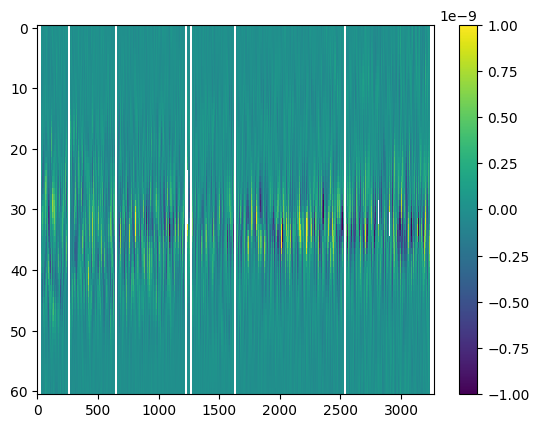

dec: [-0.79449453 -0.76949453 -0.74449453 -0.71949453 -0.69449453 -0.66949453
 -0.64449453 -0.61949453 -0.59449453 -0.56949453 -0.54449453 -0.51949453
 -0.49449453 -0.46949453 -0.44449453 -0.41949453 -0.39449453 -0.36949453
 -0.34449453 -0.31949453 -0.29449453 -0.26949453 -0.24449453 -0.21949453
 -0.19449453 -0.16949453 -0.14449453 -0.11949453 -0.09449453 -0.06949453
 -0.04449453 -0.01949453  0.00550547  0.03050547  0.05550547  0.08050547
  0.10550547  0.13050547  0.15550547  0.18050547  0.20550547  0.23050547
  0.25550547  0.28050547  0.30550547  0.33050547  0.35550547  0.38050547
  0.40550547  0.43050547  0.45550547  0.48050547  0.50550547  0.53050547
  0.55550547  0.58050547  0.60550547  0.63050547  0.65550547  0.68050547
  0.70550547]


In [6]:
def flux_diagnostic_plot():
    plt.imshow(full_fluxes['a1p'].T,aspect='auto',interpolation='nearest',vmin=-1e-9,vmax=1e-9)
    plt.colorbar()
    plt.show()
flux_diagnostic_plot()
dec_vec = decs['a1n1p'][:,0]
print('dec: {}'.format(dec_vec))

broadening... 1/1 


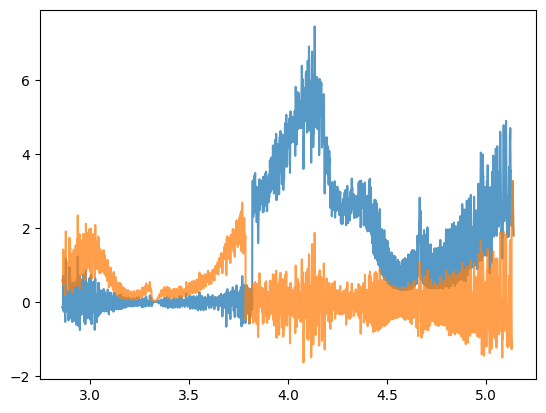

In [7]:
#load template
mrgi = silent(miniRGI)('sonora-elfowl-t', 
               wavelength_bounds=[2.86, 5.14],
               R=2700,
               load_flag = False,
               save_flag = False,
               MJy_flag = True,
               filter_name = 'JWST/NIRCam.F460M'
               )
template_params = [900, 3.5, 0.5, 0.458, 2]
f = mrgi(template_params)[0]

syn_hpf = {}
for det in ['nrs1','nrs2']:
    k = det[::3]
    #print(k)
    x_nodes = node_dict[det]    
    hpf,_ = filter_spec_with_spline(mrgi.wavelength,f,x_nodes=x_nodes)
    syn_hpf[k] = hpf

def synflux_diagnostic_plot():
    for key in syn_hpf.keys():
        synflux = syn_hpf[key]
        plt.plot(mrgi.wavelength,synflux,alpha=0.75)
    plt.show()
synflux_diagnostic_plot()

In [8]:
rvs = np.arange(-2000,2001,1)*1e3
c = 3e8
yis = np.arange(0,fluxes['a1n1s'].shape[1])

a1yind = 30
a1rvind = 2000

a2yind = 30
a2rvind = 2000

print('dec_vec: {}'.format(dec_vec[a1yind]))
print('rv: {}'.format(rvs[a1rvind]))
#print('dec_vec: {}'.format(dec_vec[a2yind]))
#print('rv: {}'.format(rvs[a2rvind]))

def MJy_2_Wm2um(w,f):
    fnu = (f*u.MJy).to(u.W/u.m**2/u.Hz)
    flam = fnu*const.c*1e6/(w * u.um)**2
    return flam.value

def _ccf_task(yi):
    rprint('{}'.format(yi))

    flux = fflux[:,yi]
    #spec = MJy_2_Wm2um(fwave,flux)
    
    ccfs = []
    for rv in rvs:
        rvf = (1 + rv/c)
        rv_wvs1 = wave1*rvf
        rv_wvs2 = wave2*rvf
        syn1 = np.interp(rv_wvs1,mrgi.wavelength,hpf1)
        syn2 = np.interp(rv_wvs2,mrgi.wavelength,hpf2)
        synflux = np.concatenate([syn1,syn2])
        ccf = np.nansum(flux*synflux)
        ccfs.append(ccf)
    return ccfs

def _ccf_task_2(yi):
    rprint('{}'.format(yi))

    #flux = fflux[:,yi]
    #spec = MJy_2_Wm2um(fwave,flux)

    d = fflux[:,yi]
    sig = ferr[:,yi]
    #print(iflux,iflux_err)
    #print()
    
    ccfs = []
    ifluxs = []
    iflux_errs = []
    for rv in rvs:
        rvf = (1 + rv/c)
        rv_wvs1 = wave1*rvf
        rv_wvs2 = wave2*rvf
        syn1 = np.interp(rv_wvs1,mrgi.wavelength,hpf1)
        syn2 = np.interp(rv_wvs2,mrgi.wavelength,hpf2)
        synflux = np.concatenate([syn1,syn2])
        
        m = synflux
        iflux = np.nansum(d*m/sig**2)/np.nansum(m*m/sig**2)
        iflux_err = 1/np.sqrt(np.nansum(m*m/sig**2))
        s = iflux/iflux_err
        
        #ccf = np.nansum(flux*synflux)
        ccfs.append(s)
        
        ifluxs.append(iflux)
        iflux_errs.append(iflux_err)
    
    np.save('temp/{}{}_if.npy'.format(yi,key),ifluxs)
    np.save('temp/{}{}_ife.npy'.format(yi,key),iflux_errs)
    return ccfs

dec_vec: -0.044494534647869295
rv: 0.0


In [9]:
outs1 = {}
outs2 = {}
for key in full_keys:
    
    fflux = full_fluxes[key]
    ferr = full_errs[key]
    fwave = full_ws[key]
    wave1 = waves[key[0:2]+'n1'+key[-1]]
    wave2 = waves[key[0:2]+'n2'+key[-1]]
    hpf1 = syn_hpf['n1']
    hpf2 = syn_hpf['n2']

    with Pool() as pool:
        #out1 = pool.map(_ccf_task,yis)
        out2 = pool.map(_ccf_task_2,yis)
    #uts1[key] = out1
    outs2[key] = out2

52

In [10]:
a2rvind

2000

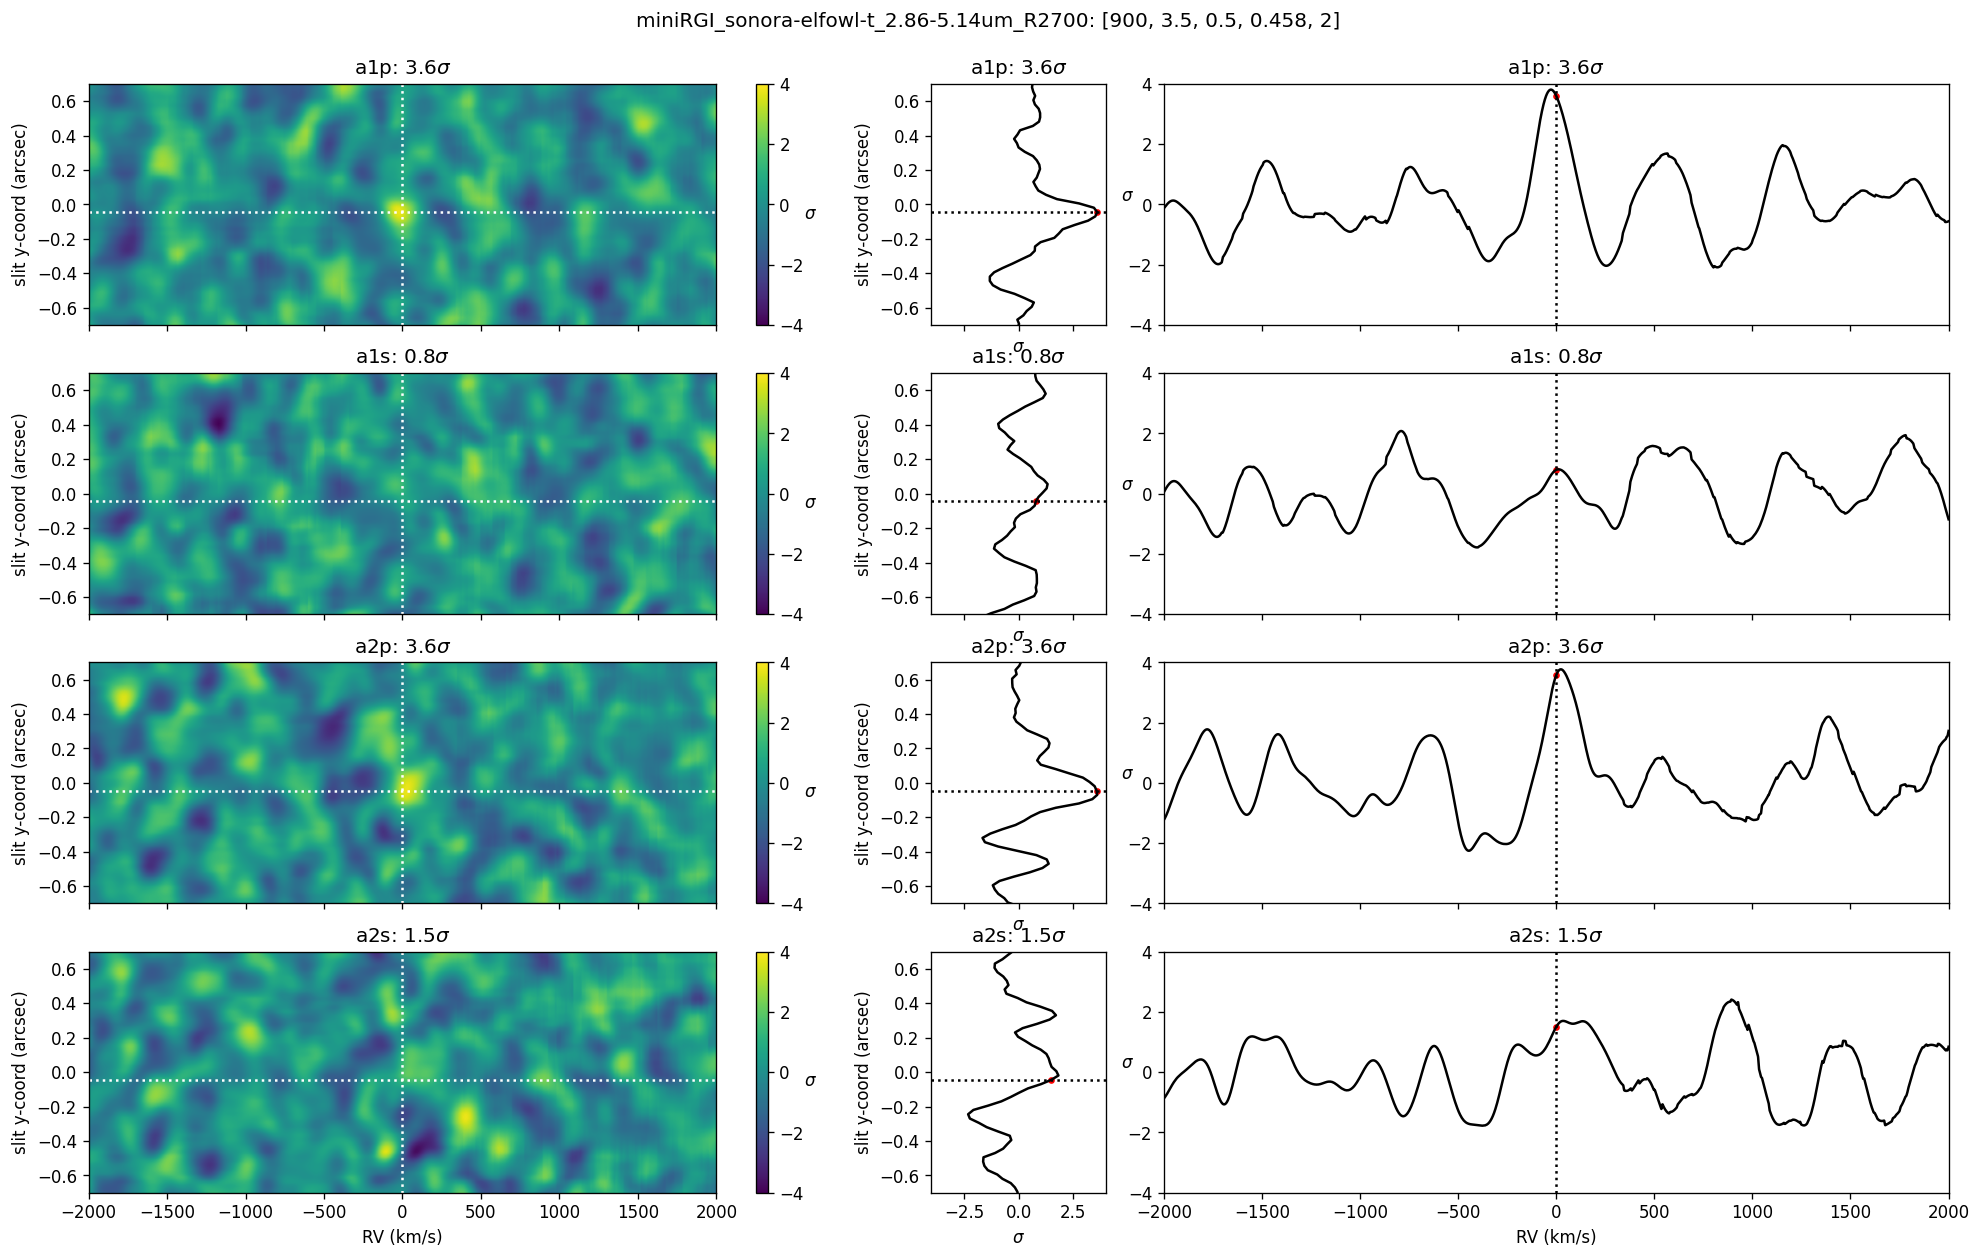

In [12]:
#def ccf_plot(outs,std_norm = False,ZL = 5):

outs = outs2
std_norm=True
ZL = 4

extent = [rvs[0]/1000,rvs[-1]/1000,dec_vec[0],dec_vec[-1]]

fig,ax = plt.subplots(4,3,figsize=(20,12),dpi=120,sharex='col',gridspec_kw={'width_ratios':[9,2,9]})

for j,key in enumerate(full_keys):
    if 'a1' in key:
        rvind = a1rvind
        yind = a1yind
    elif 'a2' in key:
        rvind = a2rvind
        yind = a2yind

    all_ccfs = np.array(outs[key])
    part_ccfs = np.array(outs[key.replace('p','s')])

    cutv = 200e3
    lr = np.where(rvs < -cutv)[0][-1]
    rr = np.where(rvs > cutv)[0][0]

    if std_norm:
        std = np.std(np.hstack([all_ccfs[:,:lr],all_ccfs[:,rr:]]),axis=1).reshape(61,1)
    else:
        std = np.ones(all_ccfs.shape) #
    
    #ZL = 7
    YL = 0.7
    XL = 2000

    det_sig = (all_ccfs/std)[yind,rvind]
    ax[j,1].plot(det_sig,dec_vec[yind],'r.')
    ax[j,2].plot(rvs[rvind],det_sig,'r.')
    
    im = ax[j,0].imshow(all_ccfs/std,aspect='auto',origin='lower',interpolation='gaussian',vmin=-ZL,vmax=ZL,extent=extent)
    ax[j,0].axvline(x=rvs[rvind]/1000,color='w',linestyle=':')
    ax[j,0].axhline(y=dec_vec[yind],color='w',linestyle=':')
    cbar = fig.colorbar(im)
    cbar.set_label(r'$\sigma$',rotation=0)
    ax[j,0].set_ylabel(r'slit y-coord (arcsec)')
    
    ax[j,0].set_xlim([-XL,XL])
    ax[j,0].set_ylim([-YL,YL])
    
    ax[j,0].set_title(r'{}: {}$\sigma$'.format(key,np.round(det_sig,1)))
    ax[j,1].set_title(r'{}: {}$\sigma$'.format(key,np.round(det_sig,1)))
    ax[j,2].set_title(r'{}: {}$\sigma$'.format(key,np.round(det_sig,1)))

    ax[j,1].plot(all_ccfs[:,rvind]/std[:,0],dec_vec,color='k')
    ax[j,1].axhline(y=dec_vec[yind],color='k',linestyle=':')

    ax[j,1].set_xlim([-ZL,ZL])
    ax[j,1].set_ylim([-YL,YL])
    ax[j,1].set_ylabel('slit y-coord (arcsec)')
    ax[j,1].set_xlabel(r'$\sigma$',rotation=0)

    ax[j,2].plot(rvs/1000,all_ccfs[yind,:]/std[yind,:],color='k')
    ax[j,2].axvline(x=rvs[rvind]/1000,color='k',linestyle=':')
    ax[j,2].set_ylim([-ZL,ZL])
    ax[j,2].set_xlim([-XL,XL])

    ax[j,2].set_ylabel(r'$\sigma$',rotation=0,labelpad=0)
    
ax[-1,0].set_xlabel('RV (km/s)')
ax[-1,2].set_xlabel('RV (km/s)')
plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.suptitle('{}: {}'.format(mrgi.identity,template_params),y=.93)
plt.show()

a1p
iflux:7.26e-11 err:7.26e-12 ratio:10.0
____
a1s
iflux:1.606e-11 err:7.21e-12 ratio:2.23
____
a2p
iflux:5.316e-11 err:6.41e-12 ratio:8.29
____
a2s
iflux:2.393e-11 err:7.59e-12 ratio:3.15
____


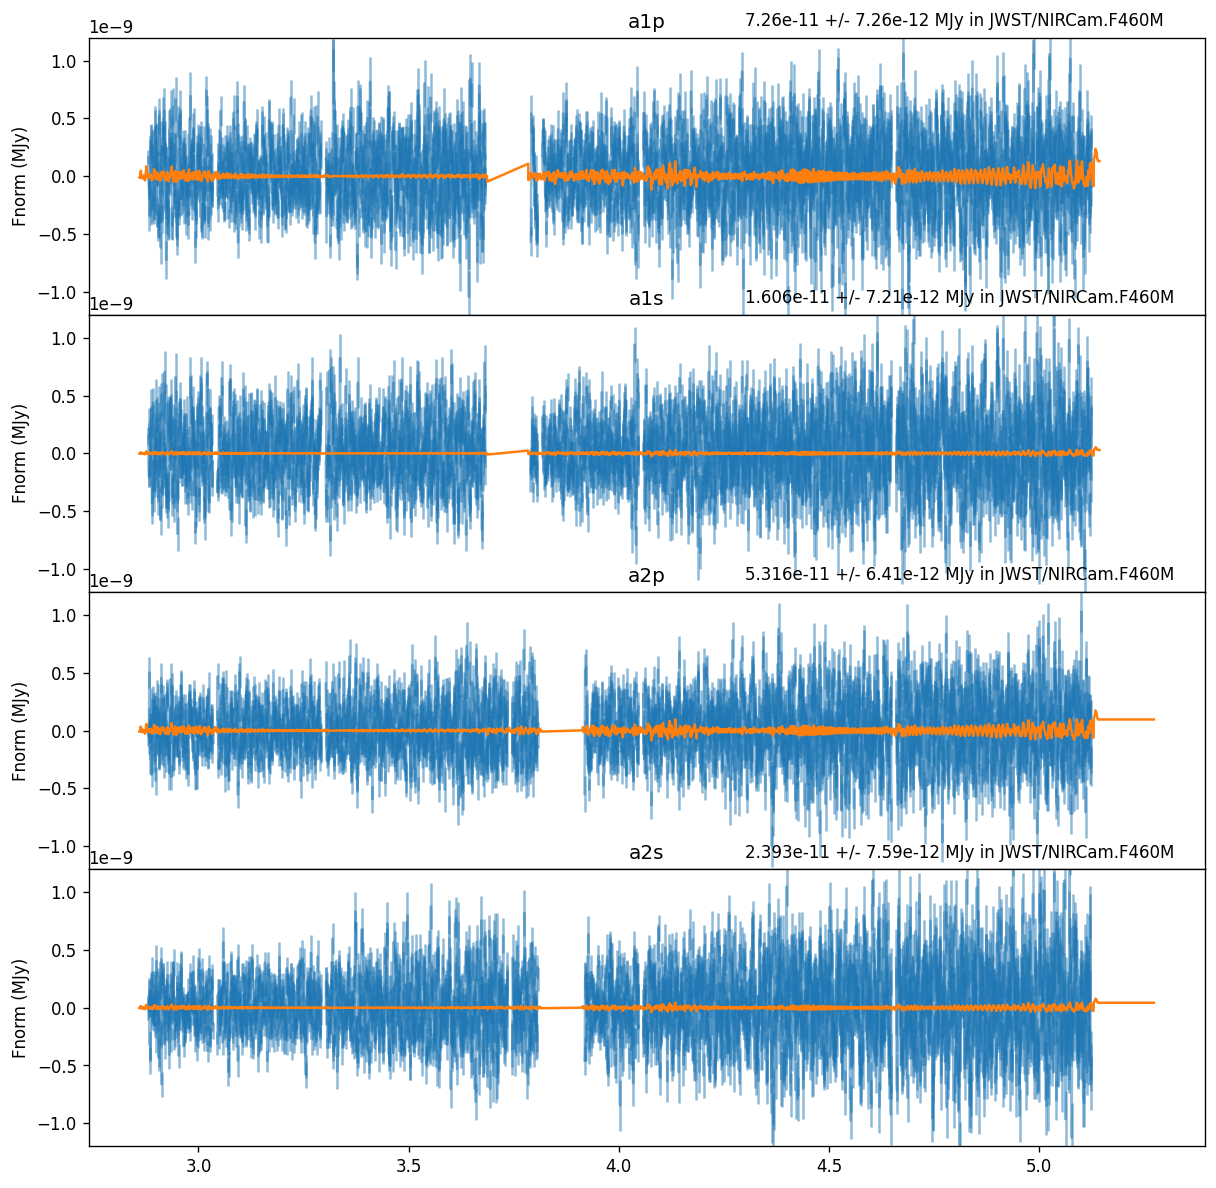

In [13]:
def best_fit_flux_plot():
    fig,ax = plt.subplots(4,1,figsize=(12,12),dpi=120,sharex=True)
    axis = {'a1p':0,'a1s':1,'a2p':2,'a2s':3}
    
    for key in full_keys:
        print(key)
    
        if 'a1' in key:
            rvind = a1rvind
            yind = a1yind
        elif 'a2' in key:
            rvind = a2rvind
            yind = a2yind
            
        fflux = full_fluxes[key]
        fwave = full_ws[key]
        ferr = full_errs[key]
        wave1 = waves[key[0:2]+'n1'+key[-1]]
        wave2 = waves[key[0:2]+'n2'+key[-1]]
        hpf1 = syn_hpf['n1']
        hpf2 = syn_hpf['n2']
        syn1 = np.interp(wave1,mrgi.wavelength,hpf1)
        syn2 = np.interp(wave2,mrgi.wavelength,hpf2)
        synflux = np.concatenate([syn1,syn2])
        synwave = np.concatenate([wave1,wave2])
        #print(synwave.shape)
    
        d = fflux[:,yind]
        m = synflux
        sig = ferr[:,yind]
    
        iflux = np.nansum(d*m/sig**2)/np.nansum(m*m/sig**2)
        iflux_err = 1/np.sqrt(np.nansum(m*m/sig**2))
        print('iflux:{} err:{} ratio:{}'.format(np.round(iflux,14),np.round(iflux_err,14),np.round(iflux/iflux_err,2)))
        print('____')
        axi = axis[key]
        ax[axi].errorbar(fwave,fflux[:,yind],yerr=ferr[:,yind],alpha=0.5)
        ax[axi].plot(synwave,synflux*iflux,zorder=10)
        ax[axi].set_title('{}'.format(key))
        ax[axi].set_ylim([-1.2e-9,1.2e-9])
        ax[axi].text(4.3,1.3e-9,'{} +/- {} MJy in {}'.format(np.round(iflux,14),np.round(iflux_err,14),mrgi.filter_name))
        ax[axi].set_ylabel('Fnorm (MJy)')
    plt.subplots_adjust(hspace=0)
    plt.show()
best_fit_flux_plot()

In [14]:
fluxs = {}
errs = {}
for key in ['a1p','a2p','a1s','a2s']:
    flux = np.zeros((4001,61))
    err = np.zeros((4001,61))
    for yi in range(0,61):
        iflux = np.load('temp/{}{}_if.npy'.format(yi,key),allow_pickle=True)
        iflux_err = np.load('temp/{}{}_ife.npy'.format(yi,key),allow_pickle=True)
        flux[:,yi] = iflux
        err[:,yi] = iflux_err
    fluxs[key] = flux
    errs[key] = err

In [15]:
#combined_flux = (f1/e1^2+f2/e2^2)/(1/e1^2+1/e2^2)
#combined_err = sqrt(1/(1/e1^2+1/e2^2))

ccfs = {}
sigs = {}
for k in ['p','s']:
    f1 = fluxs['a1'+k]#[:-60,:]
    e1 = errs['a1'+k]#[:-60,:]
    f2 = fluxs['a2'+k]#[60:,:]
    e2 = errs['a2'+k]#[60:,:]
    
    ccf1 = (f1/e1).T
    ccf2 = (f2/e2).T

    print(ccf1.shape)
    #ccf2 = ccf2
    
    cutv = 500e3
    
    rvs = np.arange(-2000,2001,1)*1e3
    lr = np.where(rvs < -cutv)[0][-1]
    rr = np.where(rvs > cutv)[0][0]
    
    std1 = np.std(np.hstack([ccf1[:,:lr],ccf1[:,rr:]]),axis=1).reshape(1,61)
    std2 = np.std(np.hstack([ccf2[:,:lr],ccf2[:,rr:]]),axis=1).reshape(1,61)
    
    e1 /= std1
    e2 /= std2
    
    cf = (f1/e1**2+f2/e2**2)/(1/e1**2+1/e2**2)
    ce = np.sqrt(1/(1/e1**2+1/e2**2))
    
    ccf = (cf/ce).T
    std = np.std(np.hstack([ccf[:,:lr],ccf[:,rr:]]),axis=1).reshape(61,1)
    ccf /= std
    
    sig = ccf[30,2000]

    ccfs[k] = ccf
    sigs[k] = sig

(61, 4001)
(61, 4001)


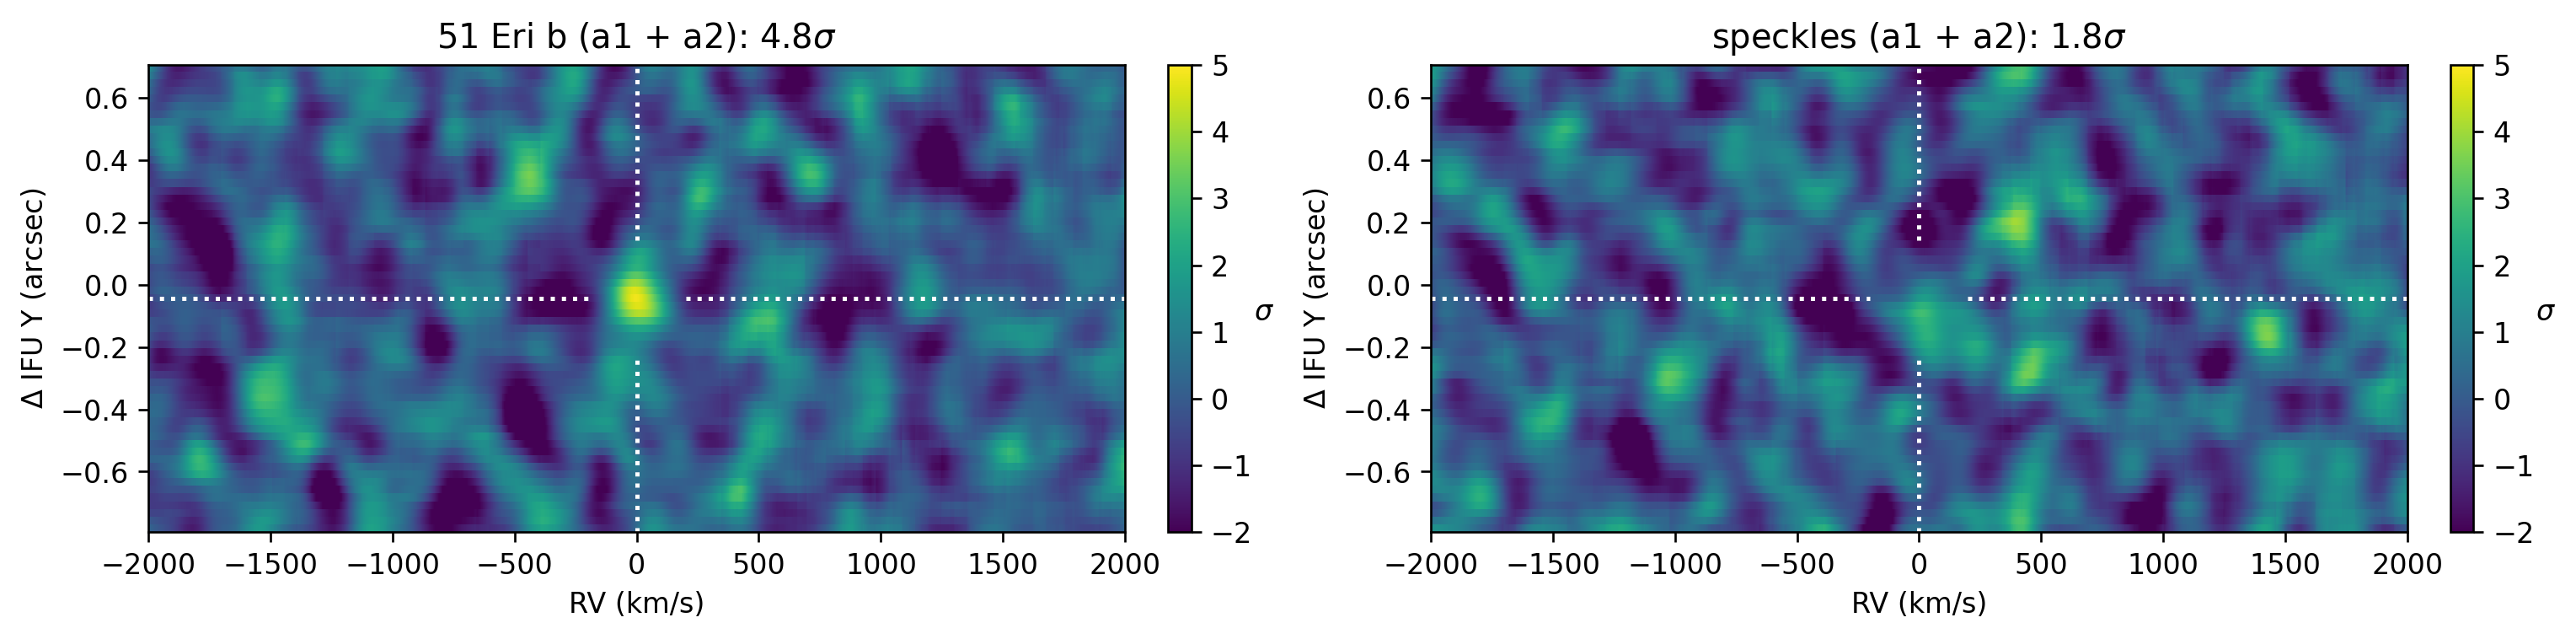

{'p': 4.837216551663506, 's': 1.7849873843620576}

In [16]:
fig,ax = plt.subplots(1,2,figsize=(15,3),dpi=240)

for i,k in enumerate(['p','s']):
    
    im = ax[i].imshow(ccfs[k],aspect='auto',extent=[-2000,2000,dec_vec[0],dec_vec[-1]],vmin=-2,vmax=5,interpolation='nearest')
    cbar = fig.colorbar(im,ax=ax[i],fraction=0.046, pad=0.04)
    cbar.set_label(r'$\sigma$',rotation=0)
    ax[i].set_xlabel('RV (km/s)')
    ax[i].set_ylabel(r'$\Delta$ IFU Y (arcsec)')

    ax[i].axhline(y=-0.044,xmax=0.45,color='white',linestyle=':')
    ax[i].axhline(y=-0.044,xmin=0.55,color='white',linestyle=':')
    ax[i].axvline(x=0,ymax=0.375,color='white',linestyle=':')
    ax[i].axvline(x=0,ymin=0.625,color='white',linestyle=':')

ax[0].set_title(r'51 Eri b (a1 + a2): {}$\sigma$'.format(np.round(sigs['p'],1)))
ax[1].set_title(r'speckles (a1 + a2): {}$\sigma$'.format(np.round(sigs['s'],1)))

plt.subplots_adjust(wspace=0.2)
plt.show()

sigs

In [17]:
np.save('ccf_planet_trace.npy',ccfs['p'][:,2000])
np.save('ccf_speckle_trace.npy',ccfs['s'][:,2000])